# Fit and remove the goethite component

This notebook fits a polynomial to the warming portion of a Room Temperature Saturation Isothermal Remanent Magnetization (RT-SIRM) low-temperature cycling experiment and then subtracts it to approximately remove the contribution that could be due to goethite or other reversible magnetic materials. The goal in doing so is to better isolate the change in remanence associated with behavior such as the Verwey and Morin transitions.

## Introduction to goethite and its low-temperature behavior

Goethite (α-FeOOH) is a common oxyhydroxide within soils, sediments, and other oxidized materials on Earth's surface. When goethite is cooled from room temperature (~300 K) to lower temperatures, it exhibits an increase in its magnetization ([Rochette and Fillion, 1989](http://doi.org/10.1029/GL016i008p00851)). This increase is reversible when goethite is warmed back up to room temperature ([Carter-Stiglitz et al., 2006](http://doi.org/10.1016/j.palaeo.2006.01.008)). 

As a result of this low-temperature behavior, goethite exhibits an negative slope in MPMS experiments, when a sample is pulsed with a high field at room temperature and then cycled to 10K and back to room temperature. Such an experiment is known as an RT-SIRM low-temperature cycling experiment and is denoted with the MagIC method codes:

- `LP-CW-SIRM:LP-MC` (Cycling between cooling and warming: Room temperature SIRM; Measured while cooling)
- `LP-CW-SIRM:LP-MW` (Cycling between cooling and warming: Room temperature SIRM; Measured while warming)

In a sample of mixed mineralogy containing goethite, this low-temperature behavior is useful for inferring the presence of goethite. Such an interpretation can be further strengthened by data from zero-field cooled (ZFC) and field cooled (FC) remanence upon warming experiments. Such experiments both show a progressive loss of remanence upon warming that typically is continuous from the lowest temperature of the experiment (typically 10 K) to the highest temperature of the experiment (typically 300 K). Additionally, a diagnostic behavior for goethite is that the FC curve has a stronger magnetization than the ZFC curve ([Liu et al., 2006](https://doi.org/10.1029/2006JB004560)). Τhe reason for the loss in remanent magnetization upon warming in these FC/ZFC experiments, as well as the difference in the FC and ZFC magnetization, is that some of the goethite grains are acquiring a thermal remanent magnetization with more of a thermal remanence being blocked during the FC experiment ([Liu et al., 2006](https://doi.org/10.1029/2006JB004560)). Samples showing this behavior are indicative of blocking temperatures below 300 K ([Liu et al., 2006](https://doi.org/10.1029/2006JB004560)).

In summary:

> "The combination of the large discrepancy between the FC and ZFC curves, and the large and reversible increase in remanence upon cooling, are therefore diagnostic of the presence of goethite" ([Liu et al., 2006](https://doi.org/10.1029/2006JB004560)).

Goethite is not the only natural magnetic material that exhibits reversible RT-SIRM behavior. Any ferromagnetic (sensu lato) phase without a low temperature transition or isotropic point would be expected to display reversible behavior in an RT-SIRM experiment. This would include minerals such as kamacite ([Bezaeva et al., 2023](https://link.springer.com/chapter/10.1007/978-3-031-09883-3_18)), greigite, ([Chang et al., 2008](https://doi.org/10.1029/2007JB005502)), and ferrihydrite ([Bilardello et al., 2020](https://doi.org/10.1029/2020GC009037)), among others. Thus, while we discuss removing the "goethite component” in this notebook, it is important to note that depending on the nature of a sample, this approach may be removing the magnetization of a phase other than goethite.

## Removing the goethite component

While goethite's low-temperature behavior is quite useful for diagnosing its presence, it can be a nuisance for interpreting such experiments as it can obscure the behavior of other phases. There are two main approaches for dealing with this issue and removing the contribution of goethite:
- **Experimentally**: given the low N&eacute;el temperature of goethite of ~120 ºC (corresponding to 393 K), an experimental protocol heats a specimen to 400 K to demagnetize magnetization associated with goethite prior to cooling to low temperature. Such a step is incorporated in the "goethite" test where the difference between magnetization with and without this 400 K heating step is used to quantify goethite abundance ([Guyodo et al., 2006](http://doi.org/10.1016/j.epsl.2006.09.005)). See discussion of this test in [Bilardello (2019)](https://hdl.handle.net/11299/208770). This approach may not be effective for minerals with reversible RT-SIRM behavior with higher Curie or Néel temperatures.
- **Numerically**: the approach taken in this notebook is to apply a polynomial fit to the warming portion of the RTSIRM low-temperature cycling curve and to then subtract that fit from both the cooling and warming curve. This approach has been used in the literature in [Silveira et al. (2021)](https://doi.org/10.2110/jsr.2020.089) and models the goethite contribution with a polynomial fit (typically a second order polynomial), which is then subtracted from the curve. The goal is to better isolate and quantify subtle transitions within the data (such as the Morin and Verwey transitions) that may otherwise be obscured.

## Import Python packages

In [2]:
import pmagpy.rockmag as rmag
import pmagpy.ipmag as ipmag
import pmagpy.contribution_builder as cb

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Import data

Here we set the path (`dir_path`) to the example data in MagIC format, unpack the MagIC file within that folder (`'A73-7-1350-4B-01a_mpms.txt'`), create a contribution object that is a collection of these tables, and view the measurements table.

In [4]:
# set the directory path (dir_path) to the data
dir_path = '../example_data/goethite'

# set the name of the MagIC file
ipmag.unpack_magic('A73-7-1350-4B-01a_mpms.txt', 
                     dir_path = dir_path,
                     input_dir_path = dir_path)

# create a contribution object from the tables in the directory
contribution = cb.Contribution(dir_path)
measurements = contribution.tables['measurements'].df

measurements.dropna(axis=1, how='all').head() # see the first 5 measurements without empty columns

working on:  'specimens\r'
1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/goethite/specimens.txt
  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/goethite/specimens.txt
working on:  'samples\r'
1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/goethite/samples.txt
  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/goethite/samples.txt
working on:  'sites\r'
1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/goethite/sites.txt
  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/goethite/sites.txt
working on:  'locations\r'
1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/goethite/locations.txt
  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/goethite/locations.txt
working on:  'measurements\r'
240  records written to file  /Users/yimingzhang/Git

,experiment,instrument_codes,magn_mass,magn_r2_det,meas_field_dc,meas_temp,measurement,method_codes,quality,specimen,standard,timestamp
measurement name,,,,,,,,,,,,
A73-7-1350-4B-01a-LP-FC-DC-14109-0-0,A73-7-1350-4B-01a-LP-FC-DC-14109,IRM-MPMS3,0.027394,2.715563e-07,0.002531,10.000116,A73-7-1350-4B-01a-LP-FC-DC-14109-0-0,LP-FC,g,A73-7-1350-4B-01a,u,2093:06:23:05:14:35.739
A73-7-1350-4B-01a-LP-FC-DC-14109-0-1,A73-7-1350-4B-01a-LP-FC-DC-14109,IRM-MPMS3,0.027376,2.660482e-07,0.002531,10.265534,A73-7-1350-4B-01a-LP-FC-DC-14109-0-1,LP-FC,g,A73-7-1350-4B-01a,u,2093:06:23:05:14:39.928
A73-7-1350-4B-01a-LP-FC-DC-14109-0-2,A73-7-1350-4B-01a-LP-FC-DC-14109,IRM-MPMS3,0.024952,1.203919e-06,0.002531,15.057111,A73-7-1350-4B-01a-LP-FC-DC-14109-0-2,LP-FC,g,A73-7-1350-4B-01a,u,2093:06:23:05:15:12.16
A73-7-1350-4B-01a-LP-FC-DC-14109-0-3,A73-7-1350-4B-01a-LP-FC-DC-14109,IRM-MPMS3,0.022089,8.515676e-07,0.002531,20.002497,A73-7-1350-4B-01a-LP-FC-DC-14109-0-3,LP-FC,g,A73-7-1350-4B-01a,u,2093:06:23:05:15:42.989
A73-7-1350-4B-01a-LP-FC-DC-14109-0-4,A73-7-1350-4B-01a-LP-FC-DC-14109,IRM-MPMS3,0.020069,6.714368e-07,0.002531,25.103758,A73-7-1350-4B-01a-LP-FC-DC-14109-0-4,LP-FC,g,A73-7-1350-4B-01a,u,2093:06:23:05:16:16.287


## Summarize experiments

In [5]:
experiments = measurements.groupby(['specimen', 'method_codes']).size().reset_index().iloc[:, :2]
experiments

,specimen,method_codes
0,A73-7-1350-4B-01a,LP-CW-SIRM:LP-MC
1,A73-7-1350-4B-01a,LP-CW-SIRM:LP-MW
2,A73-7-1350-4B-01a,LP-FC
3,A73-7-1350-4B-01a,LP-ZFC


## Plot data

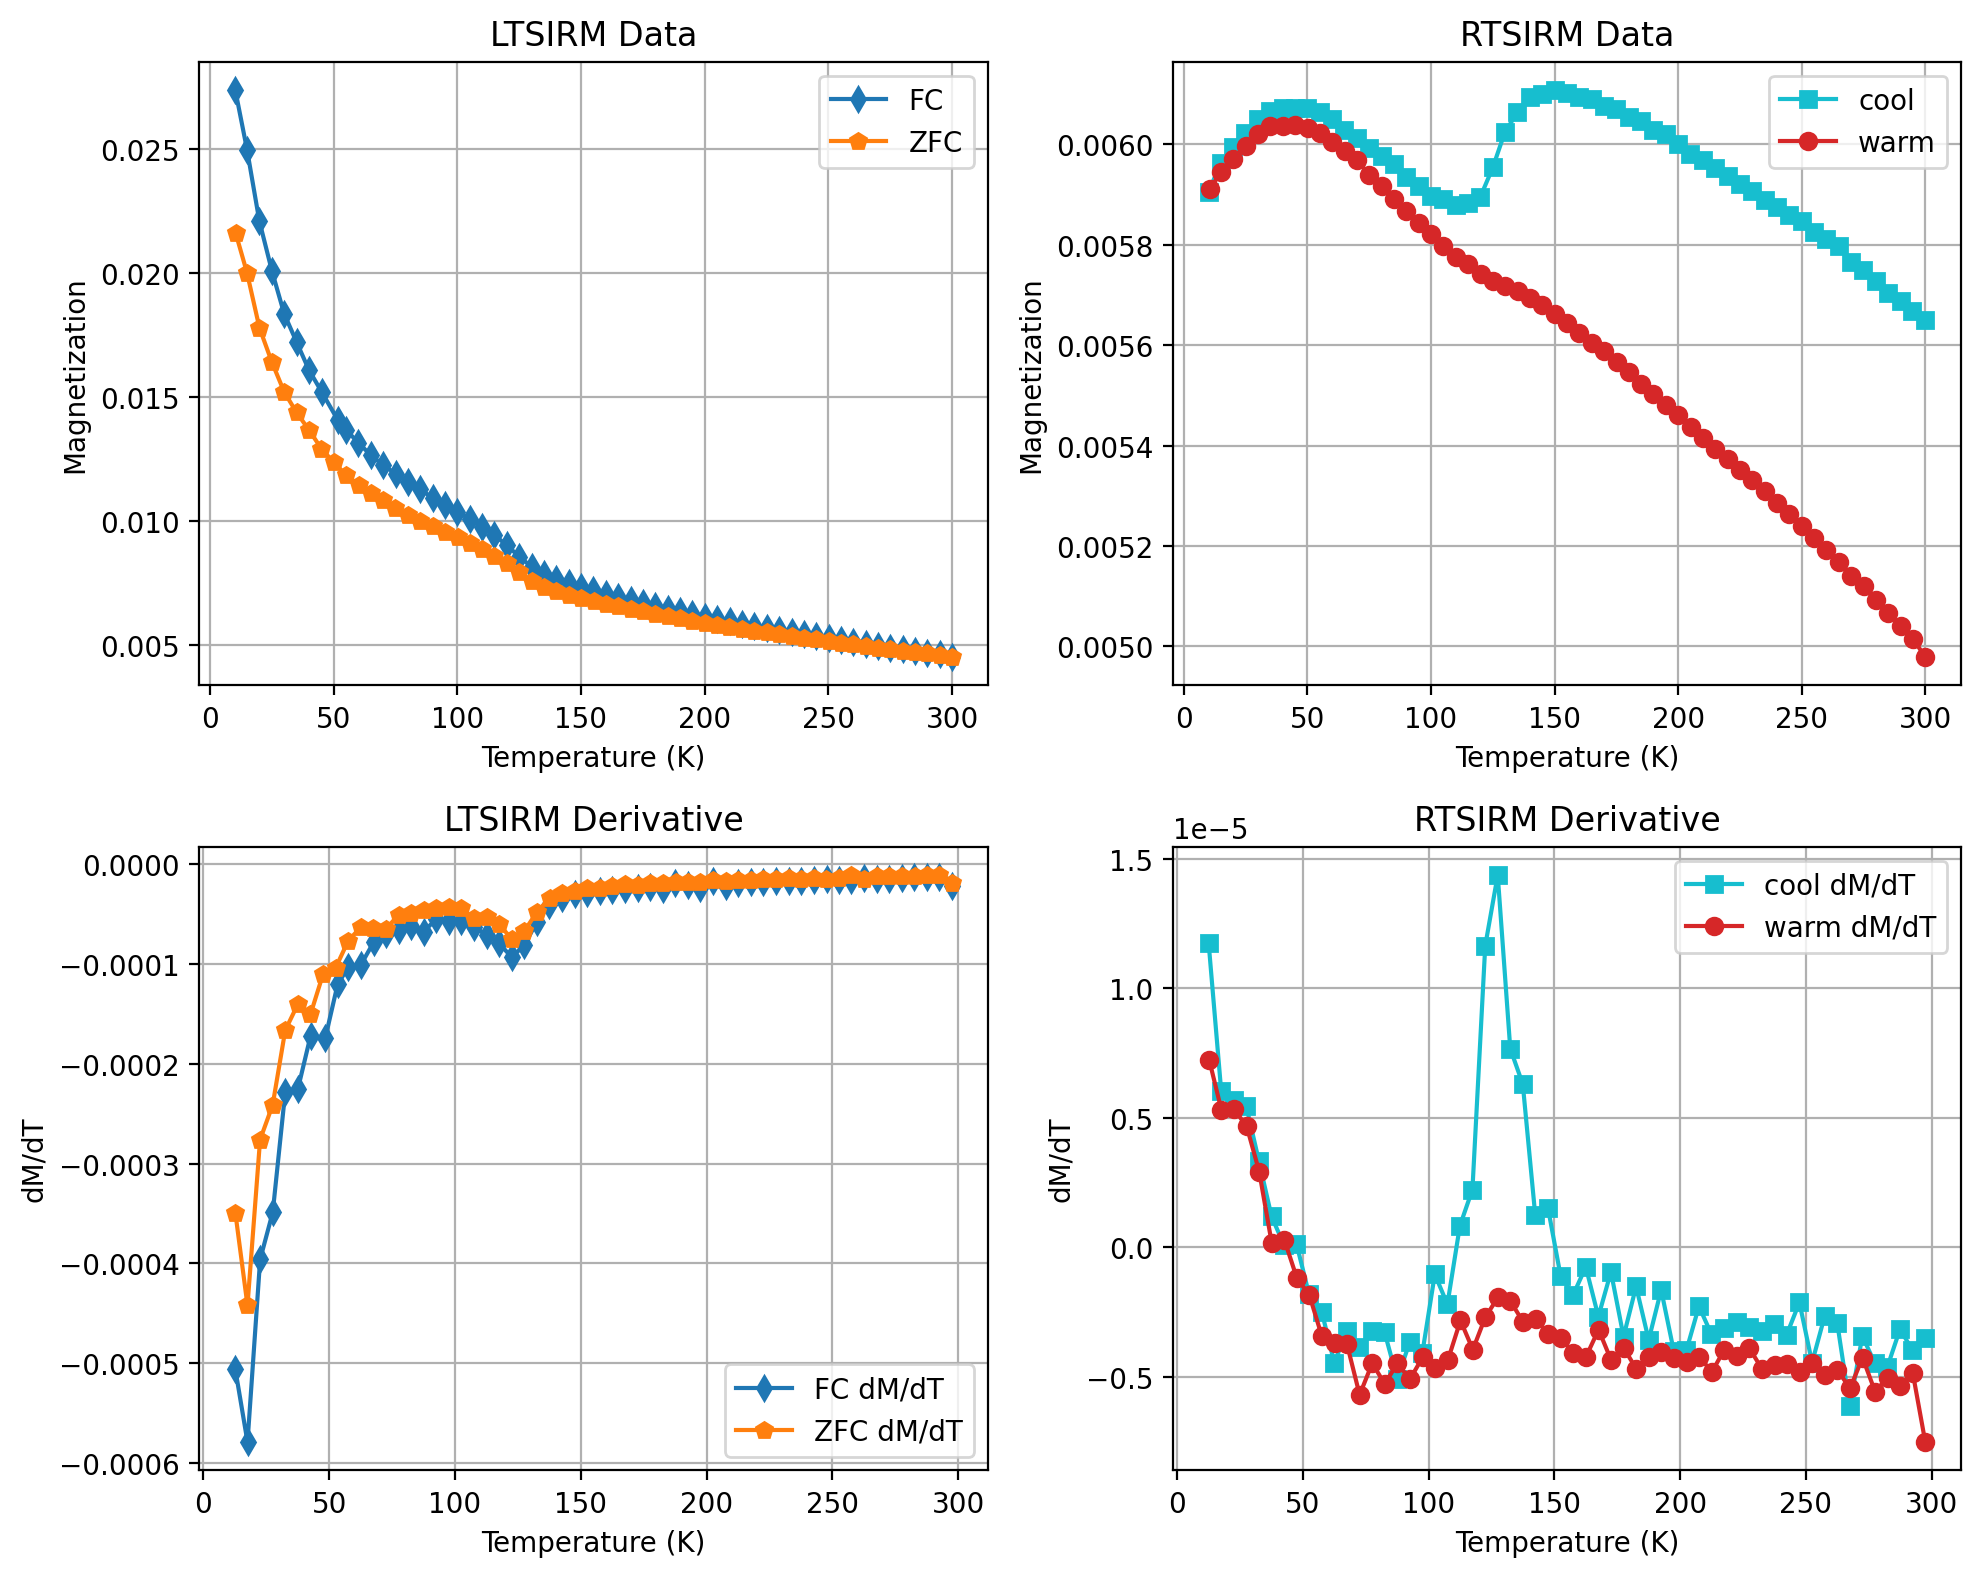

In [9]:
specimen_name = 'A73-7-1350-4B-01a'
fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data = rmag.extract_mpms_data_dc(measurements, specimen_name)
rmag.plot_mpms_dc(fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data,
                    plot_derivative=True, drop_first=True)

## Numerically remove goethite

In the interactive widgets below, a function `rmag.goethite_removal()` is used which fits a polynomial to the RTSIRM warming curve to approximately remove the contribution of the curve that is due to goethite. The uncorrected and corrected data as well as their derivatives are plotted.

In [10]:
specimen = rmag.interactive_specimen_selection(measurements)

Dropdown(description='Specimen:', options=('A73-7-1350-4B-01a',), value='A73-7-1350-4B-01a')

In [11]:
rmag.interactive_goethite_removal(measurements, specimen)

Output(layout=Layout(height='500px'))

## Apply the function `rmag.goethite_removal`

The function can also be applied without using the interactive widget in which case the parameters are entered into the function as in the example below.

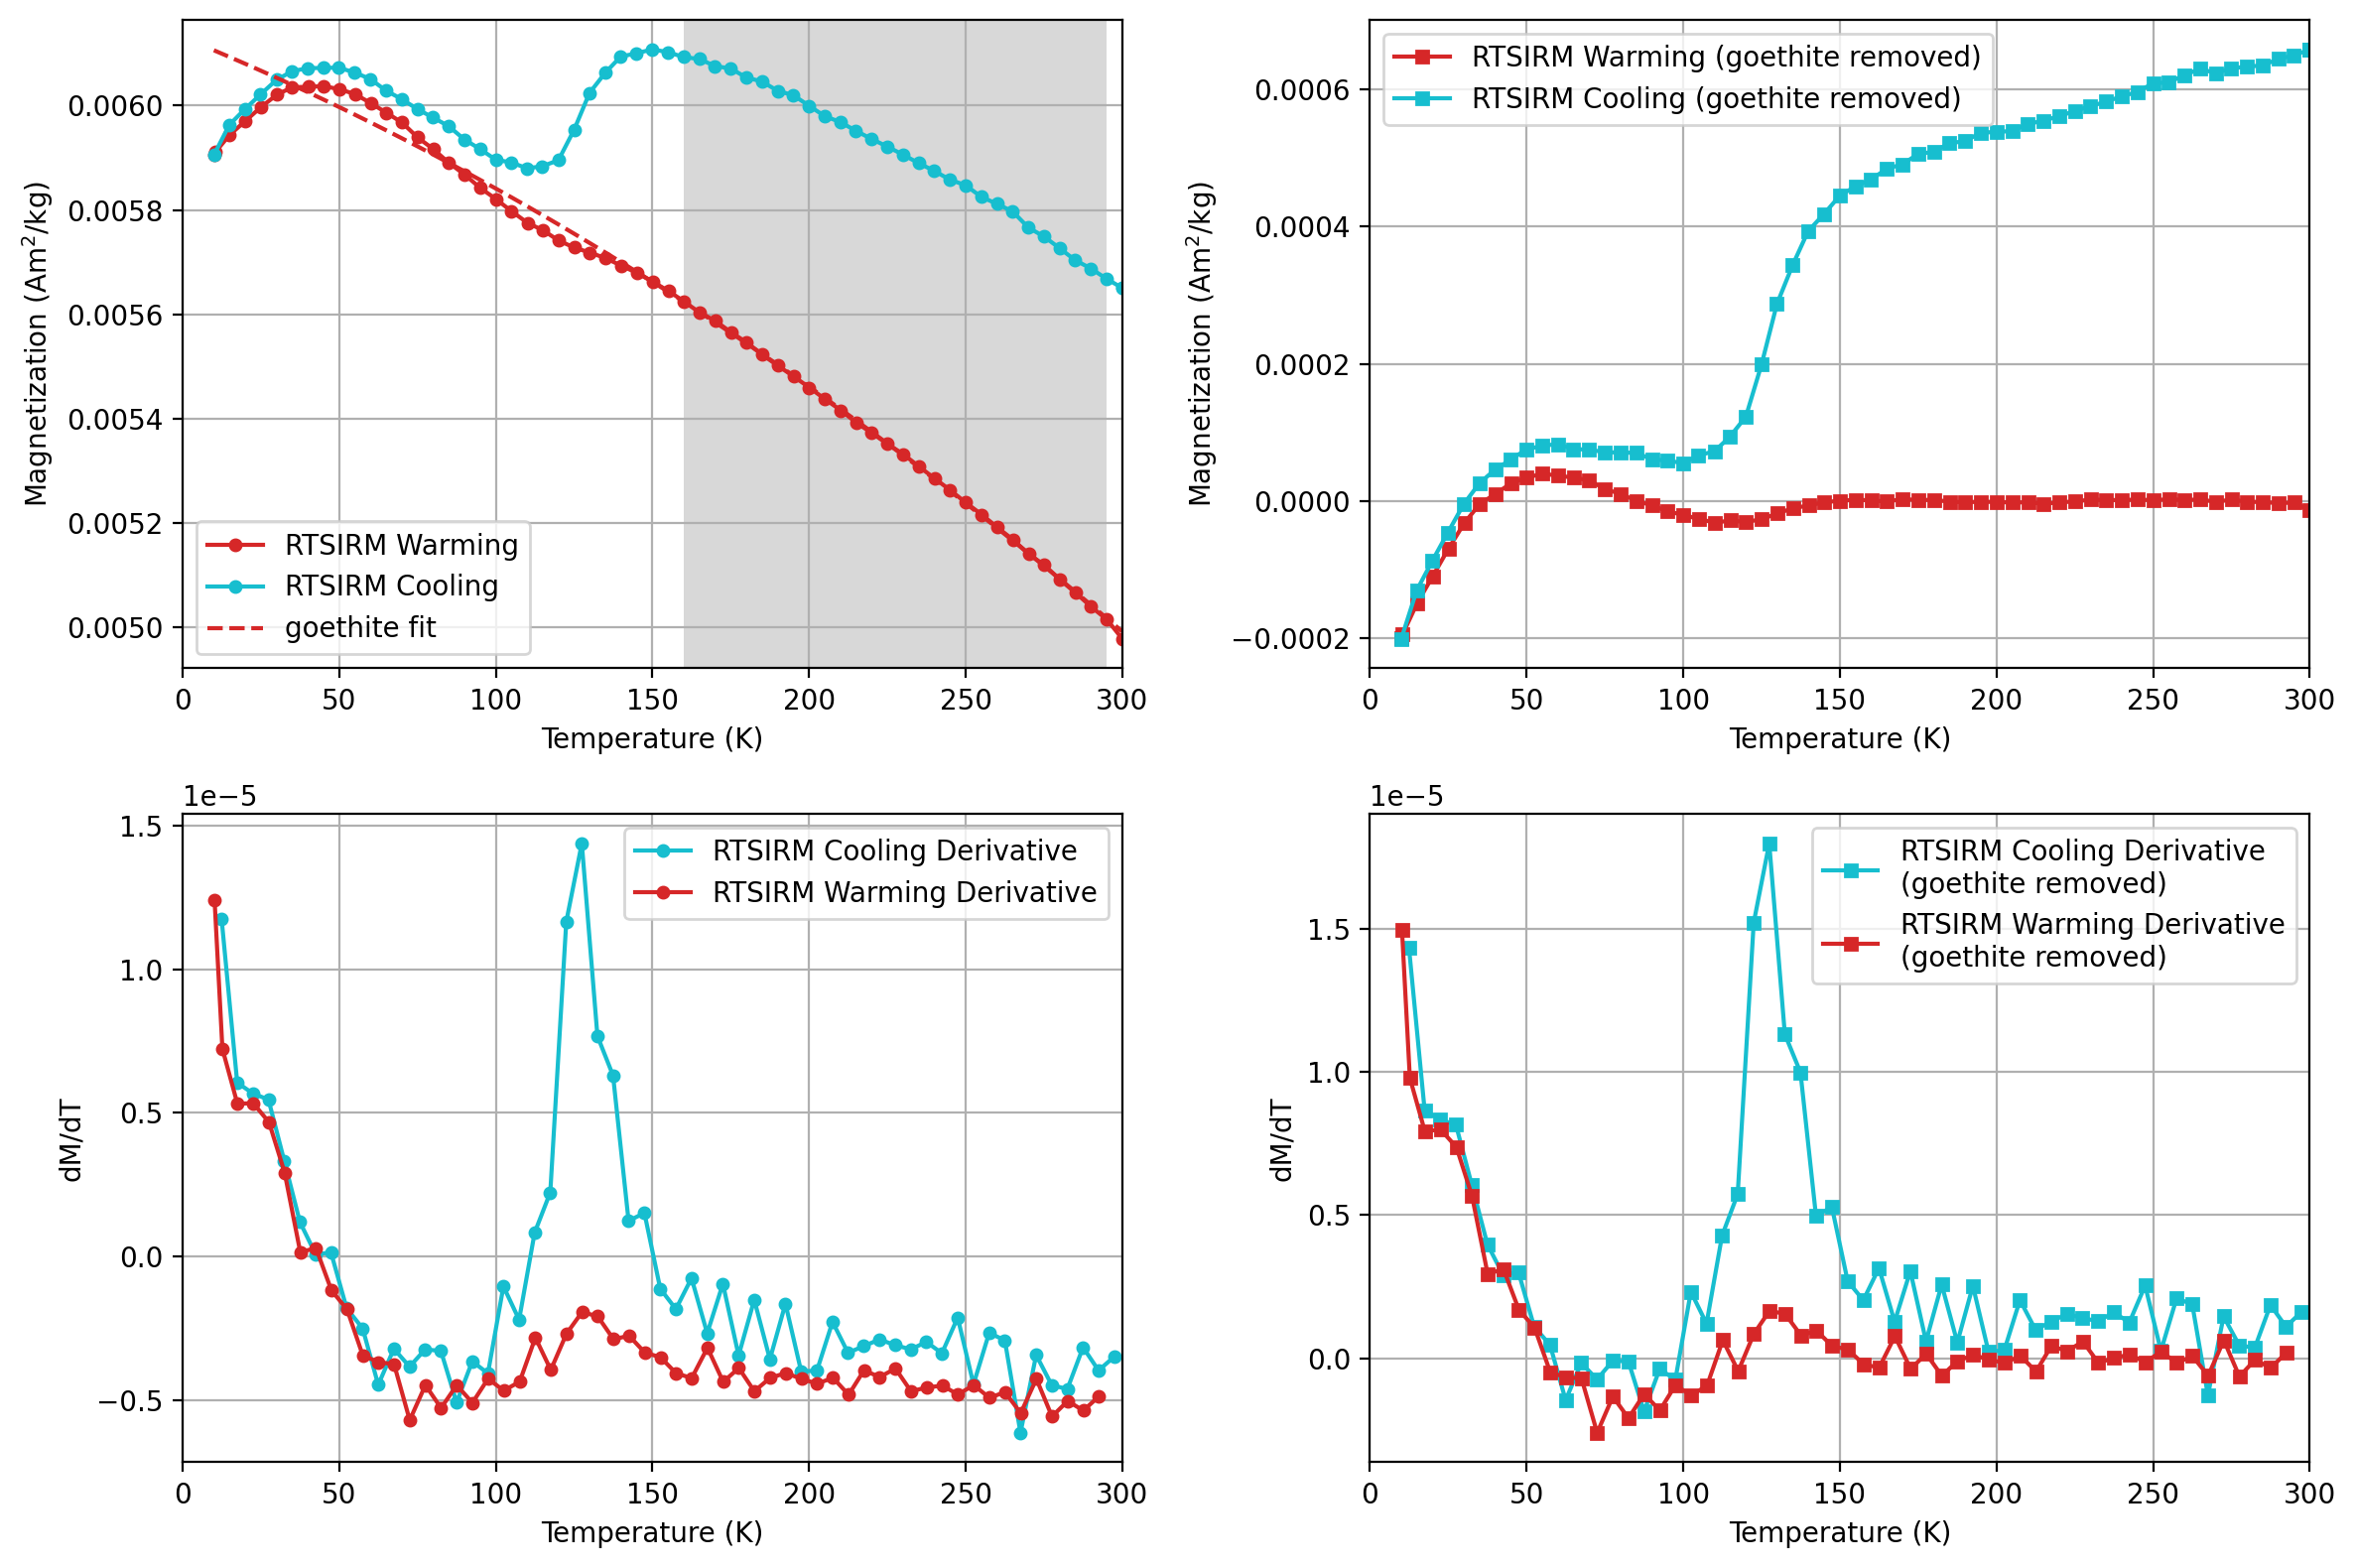

In [12]:
rmag.goethite_removal(rtsirm_warm_data, 
                     rtsirm_cool_data,
                     t_min=160, t_max=295, poly_deg=2)

## Apply the function and return the values

If the parameter `return_data=True`, the function will return DataFrames from which the goethite fit has been subtracted. 

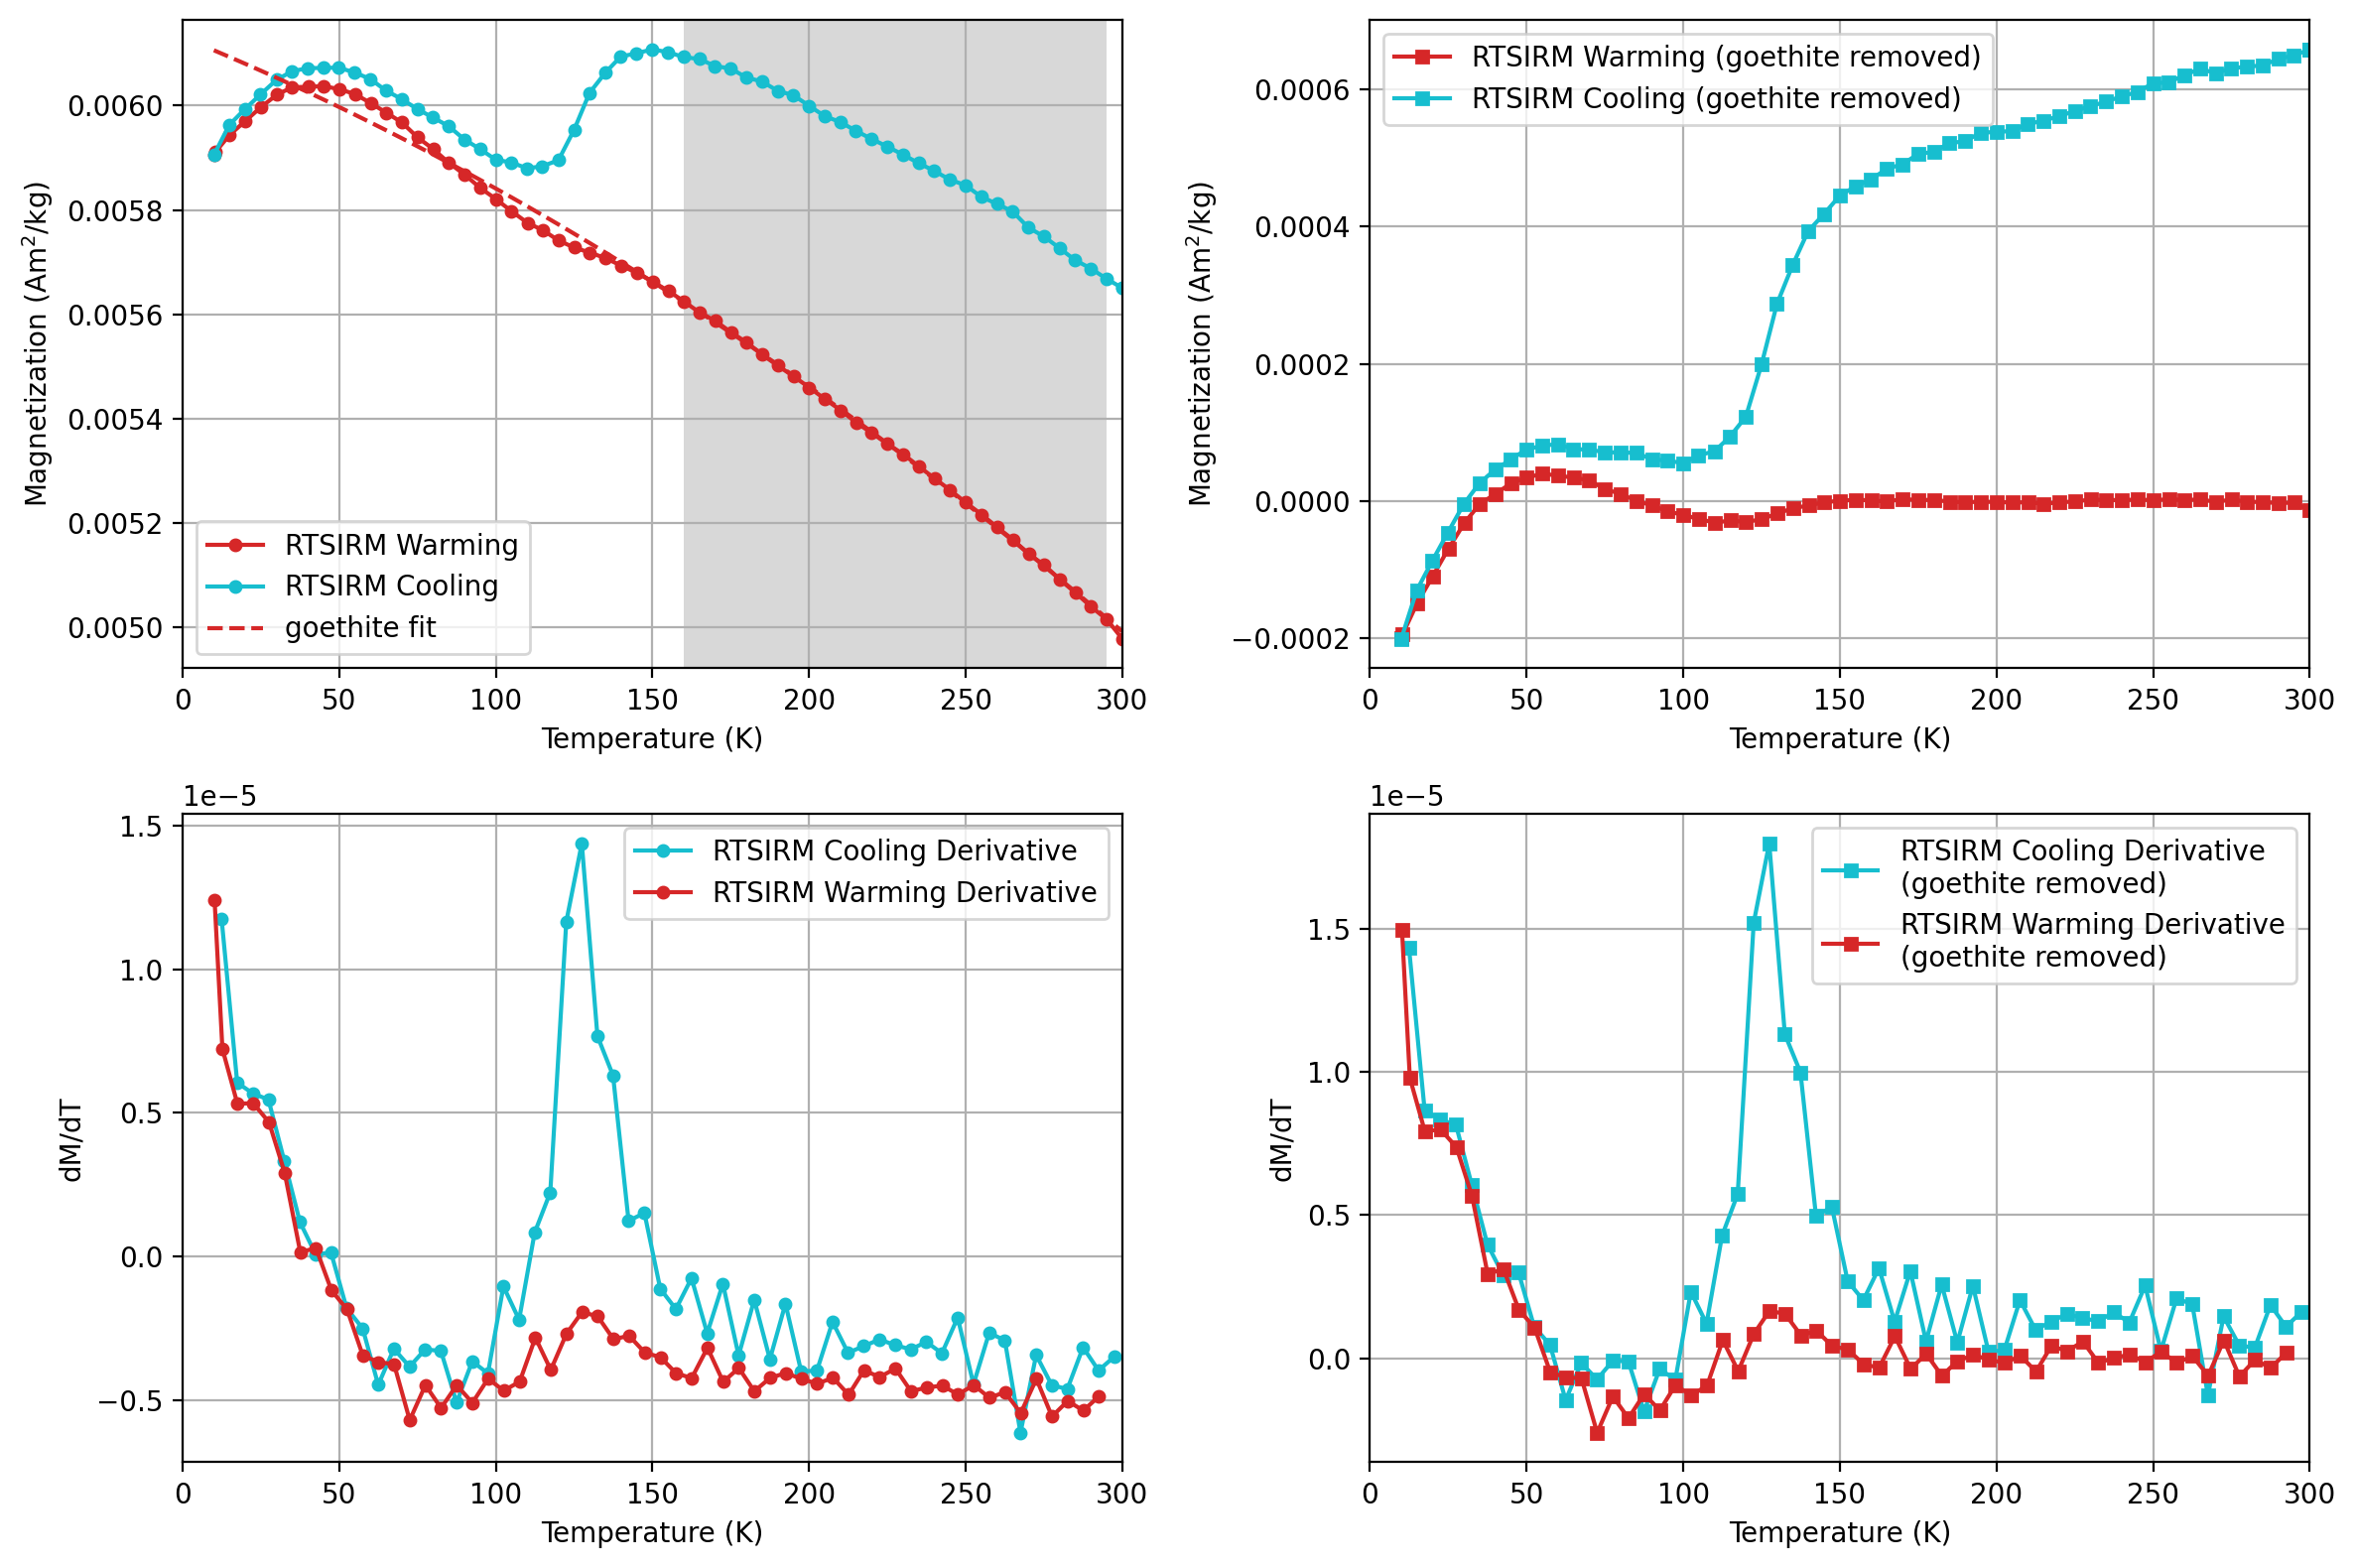

In [13]:
rtsirm_warm_adjusted, rtsirm_cool_adjusted = rmag.goethite_removal(rtsirm_warm_data, rtsirm_cool_data,
                                            t_min=160, t_max=295, poly_deg=2, return_data=True)

In [14]:
rtsirm_cool_adjusted.head()

,meas_temp,corrected_magn_mass
0,300.001099,0.000659
1,299.999817,0.000658
2,294.809082,0.000650
3,289.980713,0.000645
4,284.912720,0.000635


## References cited

Bezaeva, N.S., Badyukov, D.D., Feinberg, J.M., Kars, M., Kosterov, A., 2023, The Effect of 30 to >100 GPa Shock on the Magnetic Properties of Chinga Iron Meteorite. In: Kolotov, V.P., Bezaeva, N.S. (eds) Advances in Geochemistry, Analytical Chemistry, and Planetary Sciences. Springer, Cham. https://doi.org/10.1007/978-3-031-09883-3_18

Bilardello, D., 2019, Tinkering with the wheel: can the goethite test run more smoothly?: The IRM Quarterly, v. 29, n. 2, Summer 2019. https://hdl.handle.net/11299/208770

Bilardello, D., Banerjee, S.K., Volk, M.W.R., Solitis, J.A., and Penn, R.L., 2020, Simulation of Natural Iron Oxide Alteration in Soil: Conversion of Synthetic Ferrihydrite to Hematite Without Artificial Dopants, Observed With Magnetic Methods: Geochemistry, Geophysics, Geosystems, 21(7), e2020GC009037, https://doi.org/10.1029/2020GC009037

Carter-Stiglitz, B., Banerjee, S.K., Gourlan, A., and Oches, E., 2006, A multi-proxy study of Argentina loess: Marine oxygen isotope stage 4 and 5 environmental record from pedogenic hematite: Palaeogeography, Palaeoclimatology, Palaeoecology, v. 239, n. 1–2, p. 45–62, http://doi.org/10.1016/j.palaeo.2006.01.008.

Chang, L., Roberts, A.P., Tang, Y., Rainford, B.D., Muxworthy, A.R., and Chen, Q., 2008, Fundamental magnetic parameters from pure synthetic greigite (Fe3S4): Journal of Geophysical Research, 113, B06104, https://doi.org/10.1029/2007JB005502

Guyodo, Y., LaPara, T.M., Anschutz, A.J., Penn, R.L., Banerjee, S.K., Geiss, C.E., and Zanner, W., 2006, Rock magnetic, chemical and bacterial community analysis of a modern soil from Nebraska: Earth and Planetary Science Letters, v. 251, n. 1–2, p. 168–178, http://doi.org/10.1016/j.epsl.2006.09.005.

Liu, Q., Yu, Y., Torrent, J., Roberts, A. P., Pan, Y., and Zhu, R., 2006, Characteristic low-temperature magnetic
properties of aluminous goethite [α-(Fe, Al)OOH] explained: Journal of Geophysical Research, v. 111,
B12S34, http://dx.doi.org/10.1029/2006JB004560

Rochette, P., and Fillion, G., 1989, Field and temperature behavior of remanence in synthetic goethite:
Paleomagnetic implications: Geophysical Research Letters, v. 16, n. 8, p. 851–854, http://dx.doi.org/10.1029/GL016i008p00851

Silveira, V.E.P., dos Santos, N.B., Franco, D.R., la Terra, E.F., Feinberg, J.M., Scorzelli, R.B., Fontes, M.B., Bertolino, L.C., Cagliari, J., de Souza, M.K., and Hartmann, G.A., 2021, Environmental magnetism evidence for longshore drift distribution of Fe-bearing phases: An example from the Brazilian southeastern coastal region: Journal of Sedimentary Research, v. 91, n. 11, p. 1133–1150, http://doi.org/10.2110/jsr.2020.089.